https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

Task 2 - Tuning model's hyperparameters

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline

In [2]:
db = pd.read_csv('heart_failure_clinical_records_dataset.csv')
db.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [4]:
print(db['DEATH_EVENT'].value_counts()) 
# Unbalanced problem

0    203
1     96
Name: DEATH_EVENT, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score,recall_score, f1_score, classification_report, confusion_matrix

In [6]:
X = db.drop('DEATH_EVENT', axis =1)
Y = db['DEATH_EVENT']

In [7]:
scaler = StandardScaler()
X_proc = scaler.fit_transform(X)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X_proc, Y, test_size=0.15)

In [18]:
base_mod = LogisticRegression(solver='liblinear')
base_mod.fit(x_train, y_train)
prediction = base_mod.predict(x_test)

Logistic regression base model results
Hyperparameters: penalty: l2, C: 1
Recall score:  0.5789473684210527
F1 score:  0.6666666666666667
Model score:  0.7555555555555555


              precision    recall  f1-score   support

           0       0.74      0.88      0.81        26
           1       0.79      0.58      0.67        19

    accuracy                           0.76        45
   macro avg       0.76      0.73      0.74        45
weighted avg       0.76      0.76      0.75        45



Text(0.5, 1.0, 'Confusion Matrix, Base case')

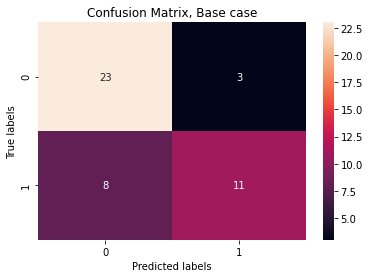

In [80]:
print('Logistic regression base model results')
print('Hyperparameters: penalty: l2, C: 1')
print('Recall score: ',recall_score(y_test,prediction))
print('F1 score: ',f1_score(y_test,prediction))
print('Model score: ', base_mod.score(x_test,y_test))
print('\n')
print(classification_report(y_test,prediction))

ax0 = plt.axes()
sns.heatmap(confusion_matrix(y_test,prediction), annot=True, ax=ax0)
ax0.set_xlabel('Predicted labels')
ax0.set_ylabel('True labels')
ax0.set_title('Confusion Matrix, Base case')

Base case with C=1 and libliner solver, model score is 0.75, f1 score for class 1 is 0.667, identifies over 50% correctly

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

#### We will search for best hyperparameters to Logistic regression model  over a random stratified K-fold CV, to avoid sampling bias (especially in a small data set) and and Random Grid Search based on mathematical distirubtions to decrease the claculation time

### Main hyperparameters to focus on in Sklearn Logistic regression model are : 

##### C
    Regulazation strength to the log-loss in the cost function, small values will indicate high regularizaion,
    meaning large values won't be 'punished' in the cost function, large C values will penalize lirge values (values the model
    predicted far from the true label)
    
##### penalty:
    the penalty to the cost function while training  ['l1', 'l2', 'none']

##### fit_intercept (bool):
    adding a bias constant (constant)

##### class_weight (dict): 
    When unbalanced classification problem, we need to take under considaration the skewed data while using
    Logistic regression, and therefore use  class weights to influence the amount of update to the model coefficeint: 
    penalizing less the majority and more the minority class (our 1 label) by inlarging the weightning on the minority class
    meaning more importance)
    
    {0:1, 1:2} or {0:0.5, 1:1} - proportion of 203:96 ~ 2:1, so penalty will be in the same proportion
    or using the function: 'class_weight.compute_class_weight' - {0: 0.73, 1:1.55}
    and of course - None will be tested 
        
##### cv (int):
    #folds in cross validation,  will be constant - 3 
    
##### scorer: 
    used ROC curve. 

In [41]:
CV = RepeatedStratifiedKFold(n_splits= 3, n_repeats=4, random_state=101)
log_reg = LogisticRegression(random_state=0, solver='liblinear')

# 2 resons for choosing different solver : a) this solver support smalles data-sets, b) supports l1 panelty

grid1 = {'C': np.random.uniform(1,20,50), 'penalty': ['l1', 'l2'], 
        'class_weight' : [{0:1, 1:1}, {0:1, 1:2}, {0:0.5, 1:1}, {0: 0.73, 1:1.55}]}

rs_cv1 = RandomizedSearchCV(estimator = log_reg, verbose=1, param_distributions=grid1,
                           n_iter=200, scoring = 'roc_auc', cv=CV, refit=True)
search_random1 = rs_cv1.fit(X_proc, Y)

Fitting 12 folds for each of 200 candidates, totalling 2400 fits


In [42]:
search_random1.best_score_

# In the previous task, after running LogisticRegression model, ROC score was 

0.8737785109379574

In [43]:
search_random1.best_params_

{'penalty': 'l1', 'class_weight': {0: 0.5, 1: 1}, 'C': 1.008604331047538}

In [44]:
results_random1 = pd.DataFrame(search_random1.cv_results_)

In [45]:
random_params1 = pd.DataFrame(search_random1.cv_results_['params'])
random_params1['mean_score']=results_random1['mean_test_score']

#converting the dictionary to tupple with values(cls_0, cls_1)
dict_list = list(random_params1['class_weight'])
cls_w = [(d[0],d[1]) for d in dict_list]

random_params1 = random_params1.assign(class_weight=cls_w)

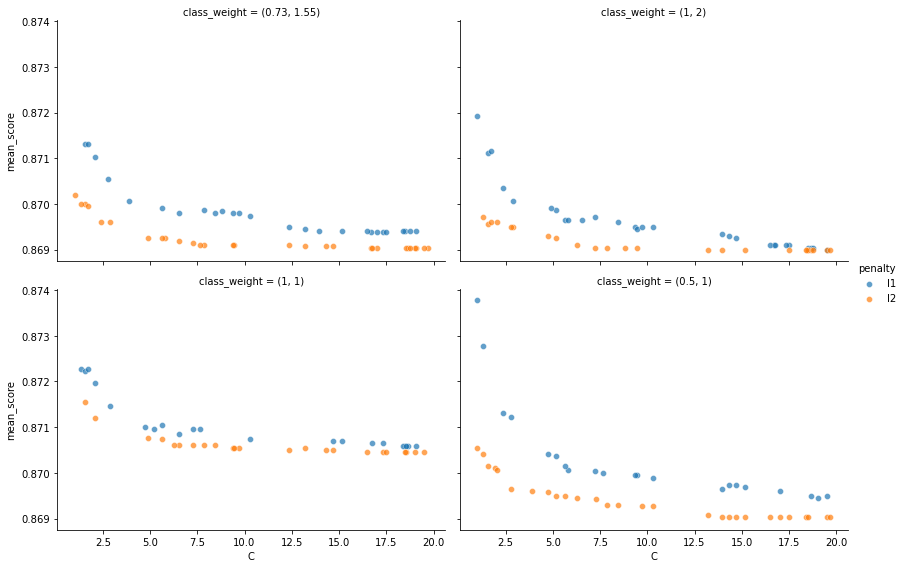

In [58]:
plot1 = sns.FacetGrid(random_params1, col='class_weight', hue = 'penalty', height=4, aspect=1.5,  col_wrap=2)
plot1.map(sns.scatterplot, 'C', 'mean_score',alpha=.7)
plot1.add_legend()

In [60]:
grid2 = {'C': np.random.uniform(1e-10,7,50), 'penalty': ['l1', 'l2'], 
        'class_weight' : [{0:1, 1:1}, {0:1, 1:2}, {0:0.5, 1:1}, {0: 0.73, 1:1.55}]}

rs_cv2 = RandomizedSearchCV(estimator = log_reg, verbose=1, param_distributions=grid2,
                           n_iter=200, scoring = 'roc_auc', cv=CV, refit=True)
search_random2 = rs_cv2.fit(X_proc, Y)

Fitting 12 folds for each of 200 candidates, totalling 2400 fits


In [61]:
search_random2.best_score_

0.8772240589332747

In [62]:
search_random2.best_params_

{'penalty': 'l1', 'class_weight': {0: 1, 1: 1}, 'C': 0.20270165940556456}

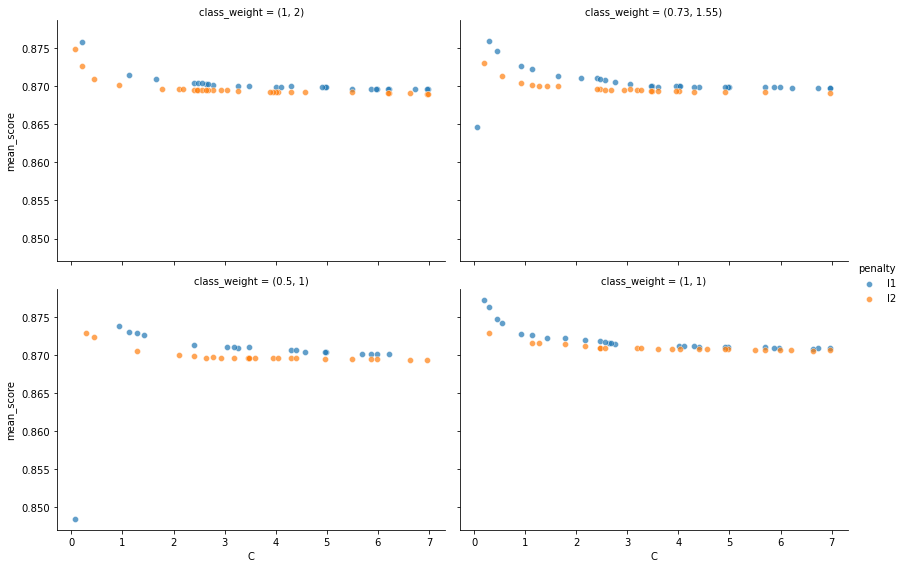

In [63]:
results_random2 = pd.DataFrame(search_random2.cv_results_)

random_params2 = pd.DataFrame(search_random2.cv_results_['params'])
random_params2['mean_score']=results_random2['mean_test_score']

#converting the dictionary to tupple with values(cls_0, cls_1)
dict_list = list(random_params2['class_weight'])
cls_w = [ (d[0],d[1]) for d in dict_list]

random_params2 = random_params2.assign(class_weight=cls_w)

plot2 = sns.FacetGrid(random_params2, col='class_weight', hue = 'penalty', height=4, aspect=1.5, col_wrap=2)
plot2.map(sns.scatterplot, 'C', 'mean_score',alpha=.7)
plot2.add_legend()


As the value of C getting smaller and close to epsilon - the model gets better mean-score results.
furthertmore, while consideratin small C values, class_weight is more important to better preformance- in comparison
between the 1st and 2nd plot, maybe its connected to small values of the input values

additionaly - l1 panelty has better execution

another insight will be that while using small values of C, class weight has better preformances with model score of 0.877,
when using relativley large C values - class weight gains more influence with model score of  0.873

Next thing to see will be the best_estimetors confusion matrix and classification report to see its results

RandomSearch1 Best Estimator results
Hyperparameters:  {'penalty': 'l1', 'class_weight': {0: 0.5, 1: 1}, 'C': 1.008604331047538}
Recall score:  0.631578947368421
F1 score:  0.6666666666666667
Model score:  0.7333333333333333


              precision    recall  f1-score   support

           0       0.75      0.81      0.78        26
           1       0.71      0.63      0.67        19

    accuracy                           0.73        45
   macro avg       0.73      0.72      0.72        45
weighted avg       0.73      0.73      0.73        45



Text(0.5, 1.0, 'Confusion Matrix, RandomSearch1')

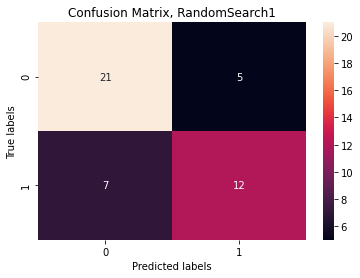

In [82]:
best_estimator_gridsrch1 = search_random1.best_estimator_
best_estimator_gridsrch1.fit(x_train, y_train)
predict1 = best_estimator_gridsrch1.predict(x_test)

print('RandomSearch1 Best Estimator results')
print('Hyperparameters: ', search_random1.best_params_)
print('Recall score: ',recall_score(y_test,predict1))
print('F1 score: ',f1_score(y_test,predict1))
print('Model score: ', best_estimator_gridsrch1.score(x_test,y_test))
print('\n')
print(classification_report(y_test,predict1))

ax1 = plt.axes()
sns.heatmap(confusion_matrix(y_test,predict1), annot=True, ax=ax1)
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels')
ax1.set_title('Confusion Matrix, RandomSearch1')

RandomSearch2 Best Estimator results
Hyperparameters:  {'penalty': 'l1', 'class_weight': {0: 1, 1: 1}, 'C': 0.20270165940556456}
Recall score:  0.5263157894736842
F1 score:  0.6451612903225806
Model score:  0.7555555555555555


              precision    recall  f1-score   support

           0       0.73      0.92      0.81        26
           1       0.83      0.53      0.65        19

    accuracy                           0.76        45
   macro avg       0.78      0.72      0.73        45
weighted avg       0.77      0.76      0.74        45



Text(0.5, 1.0, 'Confusion Matrix, RandomSearch2')

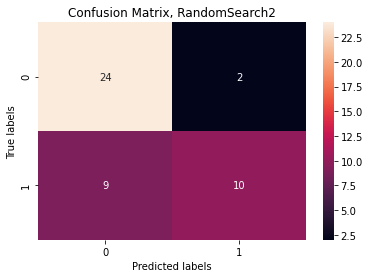

In [83]:
best_estimator_gridsrch2 = search_random2.best_estimator_
best_estimator_gridsrch2.fit(x_train, y_train)
predict2 = best_estimator_gridsrch2.predict(x_test)

print('RandomSearch2 Best Estimator results')
print('Hyperparameters: ', search_random2.best_params_)
print('Recall score: ',recall_score(y_test,predict2))
print('F1 score: ',f1_score(y_test,predict2))
print('Model score: ', best_estimator_gridsrch2.score(x_test,y_test))
print('\n')
print(classification_report(y_test,predict2))

ax2 = plt.axes()
sns.heatmap(confusion_matrix(y_test,predict2), annot=True, ax=ax2)
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels')
ax2.set_title('Confusion Matrix, RandomSearch2')

#### while over randomized cross validation the scores of both models are higher, we can see that when using train-test split the model has its limits. yet using the tuned hyperparameters with class weights - we have better results. still - not the best, we will continue with GridSearch to exhaust all possible parameters 

In [85]:
gs_cv1 = GridSearchCV(estimator = log_reg, verbose=1, param_grid=grid1, scoring = 'roc_auc', cv=CV, refit=True)
search_grid1 = gs_cv1.fit(X_proc, Y)

Fitting 12 folds for each of 400 candidates, totalling 4800 fits


In [86]:
search_grid1.best_score_

0.8737785109379574

In [87]:
search_grid1.best_params_

{'C': 1.008604331047538, 'class_weight': {0: 0.5, 1: 1}, 'penalty': 'l1'}

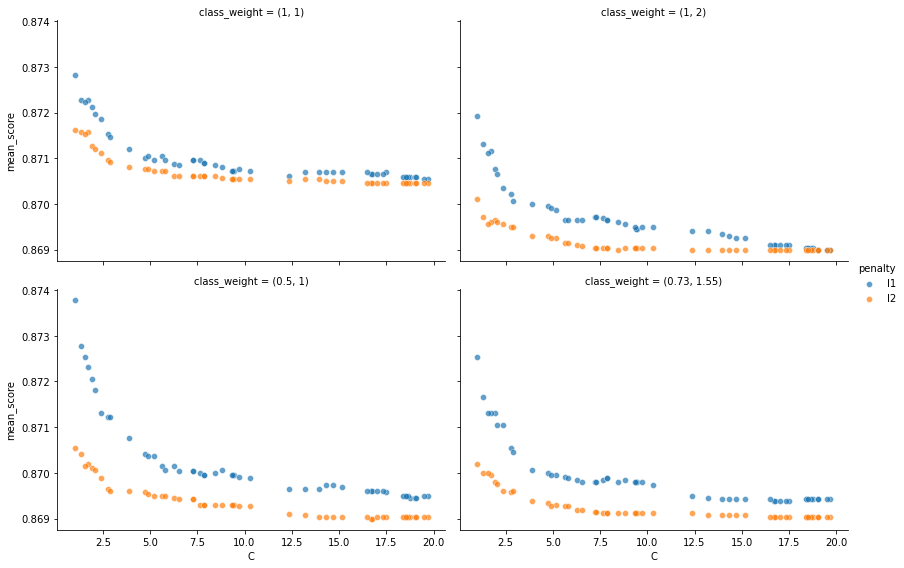

In [89]:
results_grisdsearch1 = pd.DataFrame(search_grid1.cv_results_)

grid_params1 = pd.DataFrame(search_grid1.cv_results_['params'])
grid_params1['mean_score']=results_grisdsearch1['mean_test_score']

#converting the dictionary to tupple with values(cls_0, cls_1)
dict_list = list(grid_params1['class_weight'])
cls_w = [ (d[0],d[1]) for d in dict_list]

grid_params1 = grid_params1.assign(class_weight=cls_w)

plot3 = sns.FacetGrid(grid_params1, col='class_weight', hue = 'penalty', height=4, aspect=1.5, col_wrap=2)
plot3.map(sns.scatterplot, 'C', 'mean_score',alpha=.7)
plot3.add_legend()


In [90]:
gs_cv2 = GridSearchCV(estimator = log_reg, verbose=1, param_grid=grid2, scoring = 'roc_auc', cv=CV, refit=True)
search_grid2 = gs_cv2.fit(X_proc, Y)

Fitting 12 folds for each of 400 candidates, totalling 4800 fits


In [92]:
search_grid2.best_score_

0.8772240589332747

In [93]:
search_grid2.best_params_

{'C': 0.20270165940556456, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l1'}

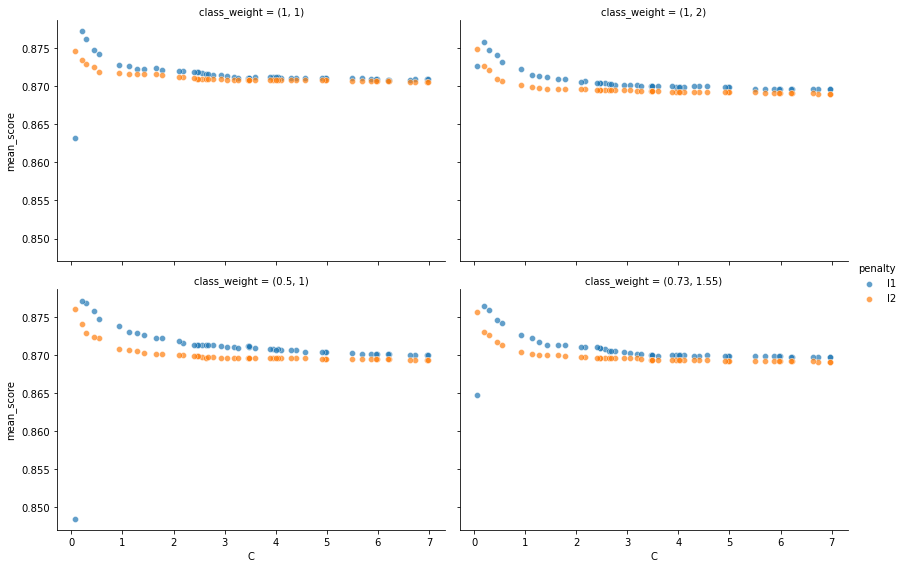

In [91]:
results_grisdsearch2 = pd.DataFrame(search_grid2.cv_results_)

grid_params2 = pd.DataFrame(search_grid2.cv_results_['params'])
grid_params2['mean_score']=results_grisdsearch2['mean_test_score']

#converting the dictionary to tupple with values(cls_0, cls_1)
dict_list = list(grid_params2['class_weight'])
cls_w = [ (d[0],d[1]) for d in dict_list]

grid_params2 = grid_params2.assign(class_weight=cls_w)

plot4 = sns.FacetGrid(grid_params2, col='class_weight', hue = 'penalty', height=4, aspect=1.5, col_wrap=2)
plot4.map(sns.scatterplot, 'C', 'mean_score',alpha=.7)
plot4.add_legend()


#### 1st input:
        using RandomSearch Vs GridSearch is less-time computations, for this search we can see that the difference of 
        error is small enough to be considerate:
        (0.8737785109379574, 0.8772240589332747 ) in compare to (0.8737785109379574,0.8772240589332747 )
#### 2nd input: 
        both algorithms got similar hyperperameters tuned in comparing of 2400 parameters sample to 4800- 
        meaning while sampling only half of the times - RandomSearch recieved same results as GridSerch